In [1]:
import pandas as pd
from scipy.spatial import KDTree
import numpy as np
from math import radians, cos, sin, asin, sqrt
import matplotlib.pyplot as plt

**Importing Datasets**

In [2]:
url2 = 'https://raw.githubusercontent.com/JeroenGuillierme/Project-MDA/main/Data/'

data = pd.read_csv(f'{url2}aed_placement_df.csv')

pd.set_option('display.max_columns', None)
pd.options.mode.copy_on_write = True

**Functions**

In [3]:
# Ensure Latitude and Longitude are not missing
data = data.dropna(subset=['Latitude', 'Longitude'])

# Add new columns
data['distance_to_aed'] = 0.0
data['distance_to_ambulance'] = 0.0
data['distance_to_mug'] = 0.0

# Filter for necessary locations
aed_locations = data[data['AED'] == 1]
ambulance_locations = data[data['Ambulance'] == 1]
mug_locations = data[data['Mug'] == 1]
intervention_locations = data[data['Intervention'] == 1]

print(len(intervention_locations), len(aed_locations), len(ambulance_locations), len(mug_locations))

11261 13916 352 73


In [4]:
# Check for empty DataFrames
if aed_locations.empty:
    print("No AED locations found.")
if ambulance_locations.empty:
    print("No Ambulance locations found.")
if mug_locations.empty:
    print("No Mug locations found.")

In [5]:
# Haversine formula
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in (kilo)meters
    return c * r

In [6]:
# Create KDTree objects
if not aed_locations.empty:
    tree_aeds = KDTree(aed_locations[['Latitude', 'Longitude']])
if not ambulance_locations.empty:
    tree_ambulances = KDTree(ambulance_locations[['Latitude', 'Longitude']])
if not mug_locations.empty:
    tree_mugs = KDTree(mug_locations[['Latitude', 'Longitude']])

In [7]:
# Calculate distances
for idx, intervention_point in intervention_locations.iterrows():
    coords = intervention_point[['Latitude', 'Longitude']].values
    distance_to_mug, _ = tree_mugs.query(coords)
    distance_to_ambulance, _ = tree_ambulances.query(coords)
    distance_to_aed, _ = tree_aeds.query(coords)
    
    # Get the nearest AED, Ambulance, and Mug coordinates
    nearest_aed_idx = tree_aeds.query(coords, k=1)[1]
    nearest_ambulance_idx = tree_ambulances.query(coords, k=1)[1]
    nearest_mug_idx = tree_mugs.query(coords, k=1)[1]
    
    nearest_aed = aed_locations.iloc[nearest_aed_idx]
    nearest_ambulance = ambulance_locations.iloc[nearest_ambulance_idx]
    nearest_mug = mug_locations.iloc[nearest_mug_idx]
    
    intervention_locations.at[idx, 'distance_to_aed'] = haversine(
        intervention_point['Longitude'], intervention_point['Latitude'],
        nearest_aed['Longitude'], nearest_aed['Latitude']
    )
    intervention_locations.at[idx, 'distance_to_ambulance'] = haversine(
        intervention_point['Longitude'], intervention_point['Latitude'],
        nearest_ambulance['Longitude'], nearest_ambulance['Latitude']
    )
    intervention_locations.at[idx, 'distance_to_mug'] = haversine(
        intervention_point['Longitude'], intervention_point['Latitude'],
        nearest_mug['Longitude'], nearest_mug['Latitude']
    )

In [8]:
# Filling in new columns for AED locations
aed_locations['distance_to_aed'] = 0
aed_locations['distance_to_ambulance'] = np.nan
aed_locations['distance_to_mug'] = np.nan

# Filling in new columns for mug locations
mug_locations['distance_to_aed'] = np.nan
mug_locations['distance_to_ambulance'] = np.nan
mug_locations['distance_to_mug'] = 0

# Filling in new columns for ambulance locations
ambulance_locations['distance_to_aed'] = np.nan
ambulance_locations['distance_to_ambulance'] = 0
ambulance_locations['distance_to_mug'] = np.nan

In [9]:
# Concatente data back together with distances
result = pd.concat([intervention_locations, aed_locations, mug_locations, ambulance_locations], axis=0)
# Reset index
result.reset_index(drop=True, inplace=True)

In [10]:
result.head(10)

,Latitude,Longitude,Intervention,Eventlevel,T3-T0,EventType,AED,Ambulance,Mug,distance_to_aed,distance_to_ambulance,distance_to_mug
0,51.20685,5.13662,1,1.0,18.884917,P003 - Cardiac arrest,0,0,0,1.239539,3.523140,8.380098
1,51.24848,4.43869,1,1.0,4.238700,P003 - Cardiac arrest,0,0,0,0.335321,1.259929,1.259929
2,51.24848,4.43869,1,1.0,12.612550,P003 - Cardiac arrest,0,0,0,0.335321,1.259929,1.259929
3,51.28273,4.42134,1,1.0,13.427900,P003 - Cardiac arrest,0,0,0,0.083377,3.262920,3.434839
4,51.28273,4.42134,1,1.0,36.619500,P003 - Cardiac arrest,0,0,0,0.083377,3.262920,3.434839
5,51.17895,4.39024,1,2.0,10.955033,P003 - Cardiac arrest,0,0,0,0.178210,1.578813,1.578813
6,51.17895,4.39024,1,2.0,11.065717,P003 - Cardiac arrest,0,0,0,0.178210,1.578813,1.578813
7,51.20520,4.76586,1,0.0,9.628933,P003 - Cardiac arrest,0,0,0,0.489422,5.373831,5.464297
8,51.20520,4.76586,1,0.0,10.428750,P003 - Cardiac arrest,0,0,0,0.489422,5.373831,5.464297
9,51.06293,4.45693,1,1.0,10.548417,P003 - Cardiac arrest,0,0,0,0.166553,2.220918,3.595612


**Histogram for distribution distances to closest AED for all interventions**

Text(0.5, 1.0, 'Distribution of distances to closest AED location')

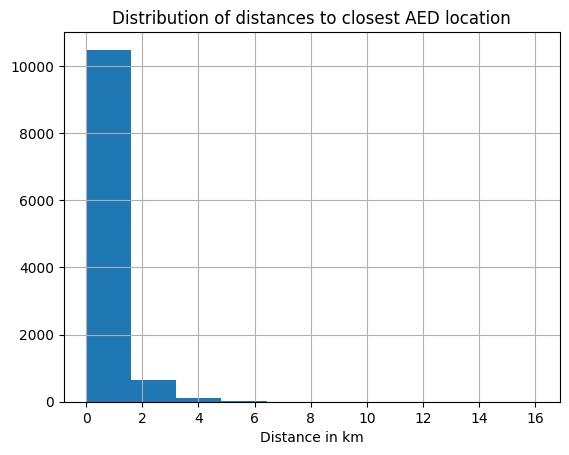

In [11]:
interventions = result[result['Intervention']==1]
interventions['distance_to_aed'].hist()
plt.xlabel('Distance in km')
plt.title('Distribution of distances to closest AED location')

**Histogram for distribution distances to closest ambulance for all interventions**

Text(0.5, 1.0, 'Distribution of distances to closest Ambulance location')

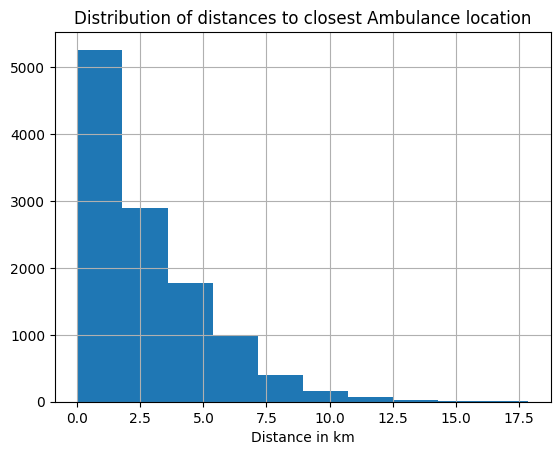

In [12]:
result['distance_to_ambulance'].hist()
plt.xlabel('Distance in km')
plt.title('Distribution of distances to closest Ambulance location')

**Histogram for distribution distances to closest mug for all interventions**

Text(0.5, 1.0, 'Distribution of distances to closest Mug location')

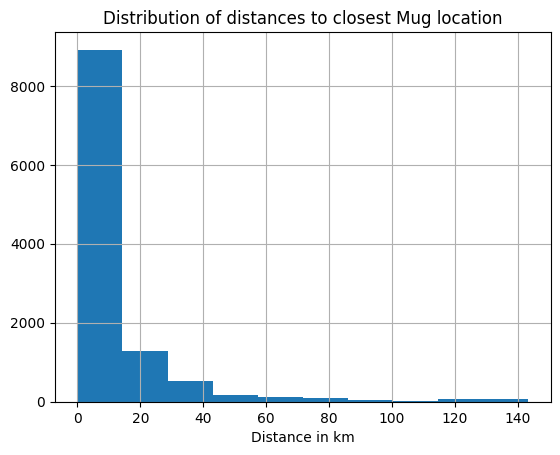

In [13]:
result['distance_to_mug'].hist()
plt.xlabel('Distance in km')
plt.title('Distribution of distances to closest Mug location')